<a href="https://colab.research.google.com/github/20193253/pdm10/blob/main/py-tensorflow/pdm10_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Transfer Learning (전이 학습)
하나의 작업을 위해 훈련된 모델을 유사 작업 수행 모델의 시작점으로 활용하는 딥러닝 접근법

- 대용량 데이터셋으로 이미 훈련된 널리 쓰이는 모델을 재사용함으로써 더 적은 레이블 지정 데이터를 사용하여 모델 훈련 가능
- 훈련 시간과 연산 리소스 감소

> e.g., 자동차를 인식하면서 학습한 결과를 트럭을 인식하는 데 사용

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


#### Model Creation

In [ ]:
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
len(TL_base.layers)

154

In [ ]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

In [ ]:
(x_train0, y_train), (x_test0, y_test) = cifar10.load_data()

# x_train=x_train/255.0
# x_test=x_test/255.0
x_train = x_train0.astype('float32')
x_test = x_test0.astype('float32')

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

# No one-hot encoding
# y_train = np_utils.to_categorical(y_train, 10)
# y_test = np_utils.to_categorical(y_test, 10)

print(x_train.shape)
print(x_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
x_train.shape,len(x_train),x_train[4].shape

((50000, 32, 32, 3), 50000, (32, 32, 3))

## Sequential model
- TL base: resnet

In [ ]:
# Set TL_base trainable or not.
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [ ]:
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_mobileNetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=3)

In [ ]:
history = model.fit(x_train, y_train, 
                    epochs=100, batch_size=64, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
782/782 [==============================] - ETA: 0s - loss: 1.5829 - accuracy: 0.4678

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


782/782 [==============================] - 53s 55ms/step - loss: 1.5829 - accuracy: 0.4678 - val_loss: 0.9881 - val_accuracy: 0.6551
Epoch 2/100
782/782 [==============================] - 42s 54ms/step - loss: 1.1634 - accuracy: 0.5962 - val_loss: 0.9003 - val_accuracy: 0.6859
Epoch 3/100
782/782 [==============================] - 42s 54ms/step - loss: 1.0546 - accuracy: 0.6308 - val_loss: 0.8559 - val_accuracy: 0.7003
Epoch 4/100
782/782 [==============================] - 42s 54ms/step - loss: 0.9931 - accuracy: 0.6541 - val_loss: 0.8296 - val_accuracy: 0.7087
Epoch 5/100
782/782 [==============================] - 42s 54ms/step - loss: 0.9446 - accuracy: 0.6699 - val_loss: 0.8039 - val_accuracy: 0.7201
Epoch 6/100
782/782 [==============================] - 43s 55ms/step - loss: 0.9196 - accuracy: 0.6778 - val_loss: 0.7856 - val_accuracy: 0.7245
Epoch 7/100
782/782 [==============================] - 42s 54ms/step - loss: 0.8822 - accuracy: 0.6918 - val_loss: 0.7744 - val_accuracy: 0.72

## 훈련 데이터와 검증 데이터에 대한 loss, accuracy 시각화

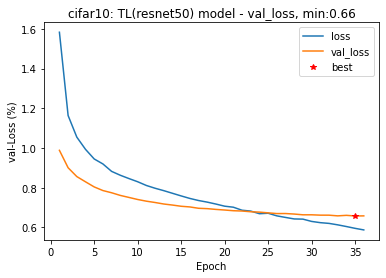

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10: TL(resnet50) model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

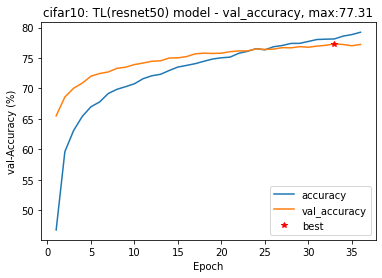

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10: TL(resnet50) model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

In [ ]:
model.evaluate(x_test, y_test, batch_size=64)

157/157 [==============================] - 7s 44ms/step - loss: 0.6580 - accuracy: 0.7722


[0.6579917073249817, 0.7721999883651733]

In [ ]:
# model.save('cifar10_SGD_ep20acc88.hdf5')
# # Load the saved model
# model = tf.keras.models.load_model('cifar10_SGD_ep20acc88.hdf5')
# model.evaluate(x_test, y_test)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

#### Visualization #1

The training/validation loss and accuracy visualizations are shown below

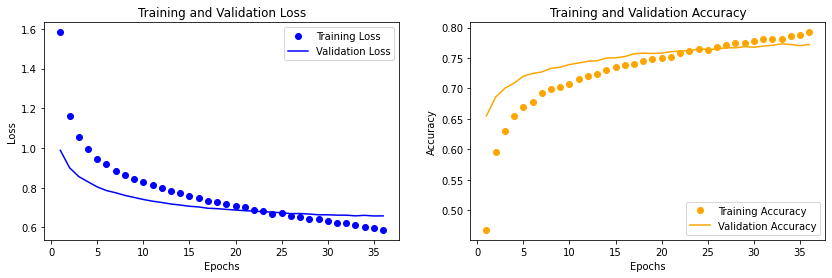

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training Accuracy', c='orange')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy', c='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Visualizing Intermediate Activations

#### Visualization #2

Let's take a look at how our images look before going into visualization techniques 

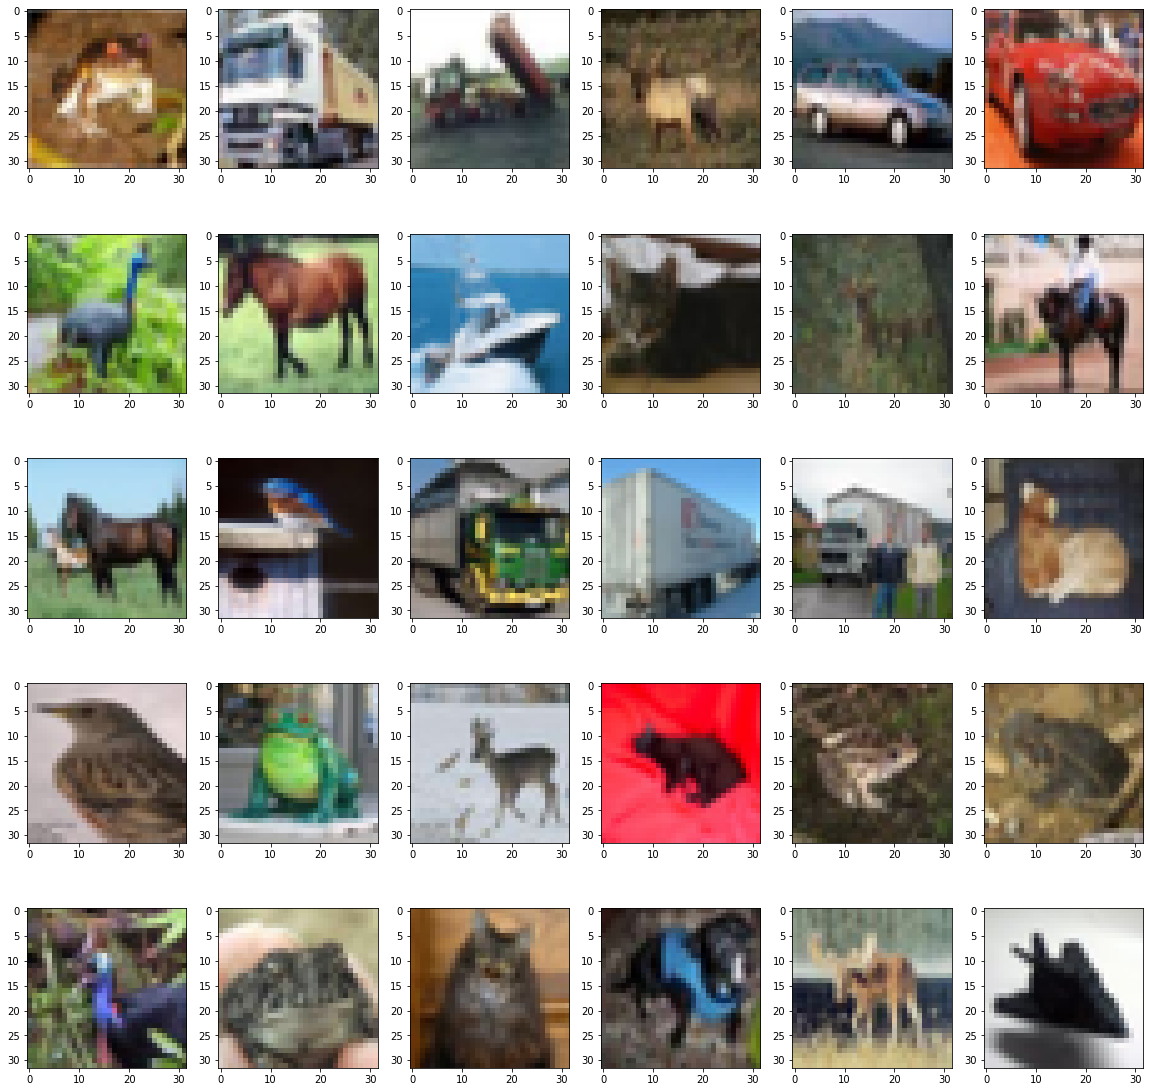

In [ ]:
plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(x_train0[i])
plt.show()

Next, let's grab the activations for the layers in MobileNetV2

In [ ]:
layer_outputs = [layer.output for layer in TL_base.layers[2:8]]

activation_model = models.Model(inputs=TL_base.input, outputs=layer_outputs)

Now let's choose an image to visualize with the activations from MobileNetV2

In [ ]:
img = x_train[29]
img=tf.image.resize(img,size=(224,224))

img_tensor = np.expand_dims(img, axis=0)
# img_tensor /= 255.

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
first_layer_activation = activations[0]

#### Visualization #3

The first image shows the excited activations of the neural network when an image of an airplane is passed through

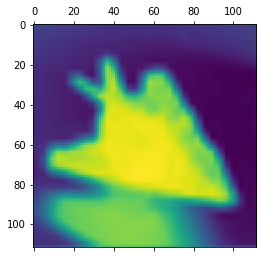

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

The original image is shown below

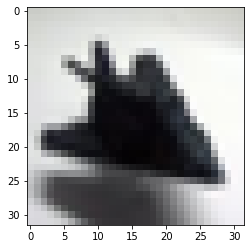

In [ ]:
plt.figure()
img = x_train0[29]
# img=tf.image.resize(img,size=(224,224))
plt.imshow(img)
plt.show()

# Transfer Learning and Visualization (CNN's)
- cifar-10
- resnet50
- mobilenetV2

> https://medium.com/@andrew.dabydeen/transfer-learning-using-resnet50-and-cifar-10-6242ed4b4245

### Transfer learning (imagenet)
- ImageNet dataset 
    - 1.4 million labeled images 
    - 1,000 different classes  
    
tensorflow.keras.applications
- Xception
- Inception V3
- ResNet50
- VGG16
- VGG19
- MobileNet

> [ref1-architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet](https://towardsdatascience.com/architecture-comparison-of-alexnet-vggnet-resnet-inception-densenet-beb8b116866d)

> [ref2-imagenet-vggnet-resnet-inception-xception-keras](https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/)

This Colab notebook demonstrates transfer learning with a pretrained ConvNet: MobileNetV2

0.   Data pipeline
1.   Baseline model: train a simple CNN from scratch
2.   Transfer learning: pretraiend ConvNet as a feature extractor
3.   Transfer learning: fine-tune a pretrained ConvNet
4.   Test accuracy & visualize predictions



Before beginning, let's load the appropriate libraries needed for this notebook

# ConvNet: MobileNetV2

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


## Load data 
- Use total data

In [ ]:
from keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

170508288/170498071 [==============================] - 3s 0us/step
Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


---

### Visualize Dataset

Use the `display_images` to view some of the images and their class labels.

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


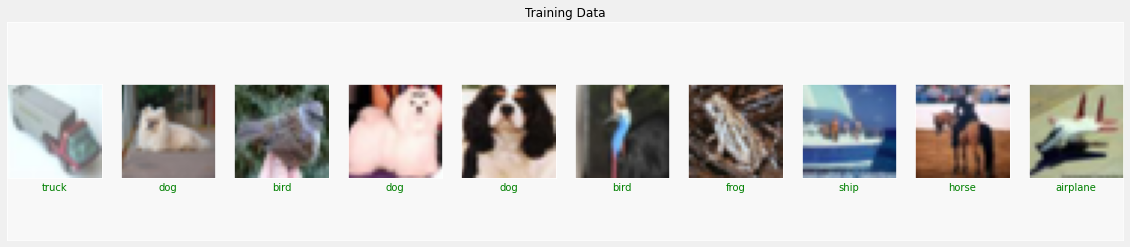

In [ ]:
display_images(trainX, trainy, trainy, "Training Data" )

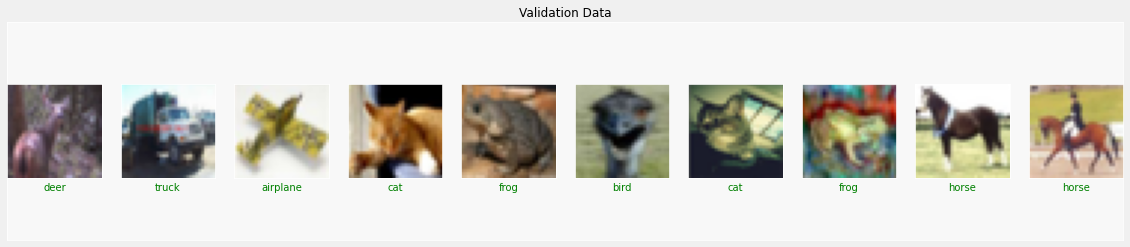

In [ ]:
display_images(testX, testy, testy, "Validation Data" )

## *Preprocess the dataset*

In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims


In [ ]:
x_train = preprocess_image_input(trainX)
x_test = preprocess_image_input(testX)

In [ ]:
x_train.shape,len(x_train),x_train[4].shape

((50000, 32, 32, 3), 50000, (32, 32, 3))

In [ ]:
y_train=trainy
y_test=testy
y_train.shape,y_test.shape

((50000, 1), (10000, 1))

## Transfer learning 

Now let's see how transfer learning can help achieve better results.

- Feature extractor

> Use MobileNetV2 as a feature extractor and add a classifier on top of it.

## Define the Network
We will be performing transfer learning on **MobileNetV2** available in Keras.
- We'll load pre-trained **imagenet weights** to the model.
- We'll choose to retain all layers of **MobileNetV2** along with the final classification layers.

In [ ]:
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
  #   Unfreeze top layers for fine tuning
  TL_base.trainable = False
  return TL_base(inputs)


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it. 
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model


model = define_compile_model()

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0        

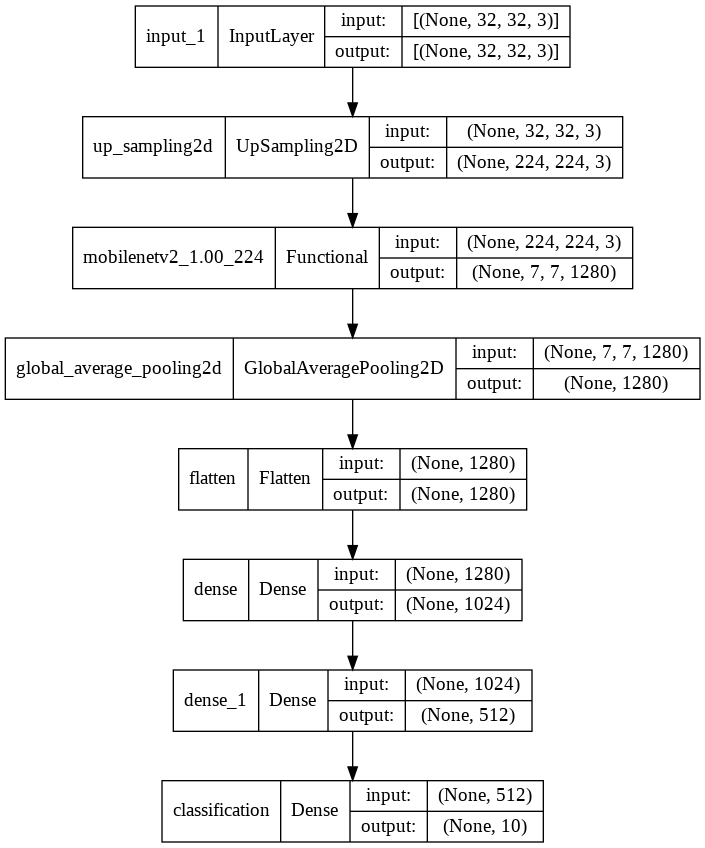

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_F.png')

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

## Train the model

In [ ]:
%%time
EPOCHS = 100
BATCH_SIZE = 50  # 32, 50, 64, 100
history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, 
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 1/100
 999/1000 [============================>.] - ETA: 0s - loss: 1.1159 - accuracy: 0.6142

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1000/1000 [==============================] - 56s 47ms/step - loss: 1.1155 - accuracy: 0.6143 - val_loss: 0.9662 - val_accuracy: 0.6644
Epoch 2/100
1000/1000 [==============================] - 42s 42ms/step - loss: 0.8637 - accuracy: 0.6954 - val_loss: 0.8359 - val_accuracy: 0.7050
Epoch 3/100
1000/1000 [==============================] - 46s 46ms/step - loss: 0.7928 - accuracy: 0.7216 - val_loss: 0.8012 - val_accuracy: 0.7233
Epoch 4/100
1000/1000 [==============================] - 42s 42ms/step - loss: 0.7464 - accuracy: 0.7385 - val_loss: 0.8416 - val_accuracy: 0.7005
Epoch 5/100
1000/1000 [==============================] - 46s 46ms/step - loss: 0.7128 - accuracy: 0.7509 - val_loss: 0.7747 - val_accuracy: 0.7317
Epoch 6/100
1000/1000 [==============================] - 46s 46ms/step - loss: 0.6812 - accuracy: 0.7627 - val_loss: 0.7553 - val_accuracy: 0.7327
Epoch 7/100
1000/1000 [==============================] - 46s 46ms/step - loss: 0.6567 - accuracy: 0.7701 - val_loss: 0.7124 - val_

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 7s 35ms/step - loss: 0.6907 - accuracy: 0.7654


[0.6907304525375366, 0.7653999924659729]

## 훈련 데이터와 검증 데이터에 대한 loss, accuracy 시각화

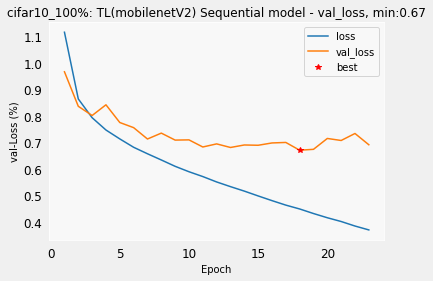

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],2)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

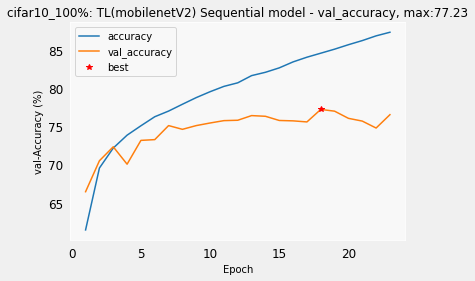

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],2)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()

### Visualization loss & accuracy

The training/validation loss and accuracy visualizations are shown below

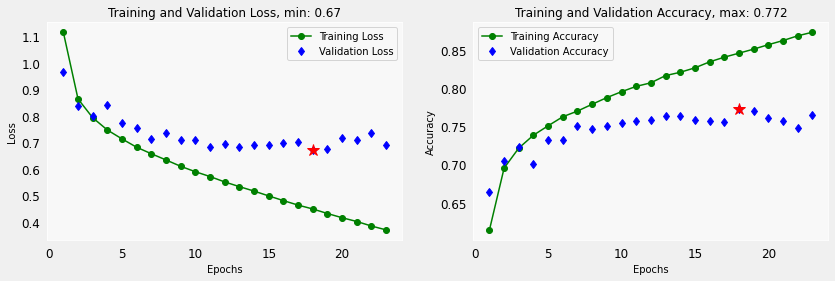

In [ ]:
# More graphs of loss and accuracy
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Visualize predictions
We can take a look at the predictions on the validation set.

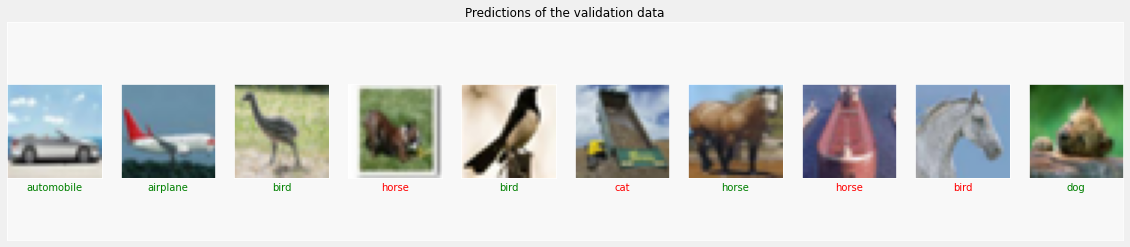

In [ ]:
probabilities = model.predict(x_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

# **Fine tuning**

In [ ]:
tf.keras.backend.clear_session()  # For memory

In [ ]:
'''
Feature Extraction is performed by MobileNetV2 pretrained on imagenet weights. 
Input size is 224 x 224.
'''
def feature_extractor_fine_tuning(inputs):

  TL_base = MobileNetV2(input_shape=(224, 224, 3),
                            include_top=False,
                            weights='imagenet')
#   Unfreeze top layers for fine tuning
  TL_base.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 107

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in TL_base.layers[:fine_tune_at]:
    layer.trainable =  False

  return TL_base(inputs)

def final_model_ft(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    fine_feature_extractor = feature_extractor_fine_tuning(resize)
    classification_output = classifier(fine_feature_extractor)

    return classification_output

def define_compile_model_ft():
  inputs = tf.keras.layers.Input(shape=(32,32,3))
  
  classification_output = final_model_ft(inputs) 
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)
 
  model.compile(optimizer='SGD', 
                loss='sparse_categorical_crossentropy',  # y_train is NOT one-hot encoded!
                metrics = ['accuracy'])
  
  return model

model = define_compile_model_ft()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                             

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10pct100_mobileNetV2F_SGD_FT_best_weights.{epoch:03d}-{val_accuracy:.3f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

## Train the fine-tuned model

In [ ]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 100
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [ ]:
%%time
BATCH_SIZE = 50  # 32, 50, 64, 100
history_fine = model.fit(x_train, y_train, 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    validation_data = (x_test, y_test), 
                    batch_size=BATCH_SIZE,
                    callbacks=[mc_callback,es_callback])

Epoch 24/123
 999/1000 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.7731

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1000/1000 [==============================] - 58s 55ms/step - loss: 0.6653 - accuracy: 0.7731 - val_loss: 1.2610 - val_accuracy: 0.5891
Epoch 25/123
1000/1000 [==============================] - 58s 58ms/step - loss: 0.3068 - accuracy: 0.8951 - val_loss: 0.6743 - val_accuracy: 0.7810
Epoch 26/123
1000/1000 [==============================] - 58s 58ms/step - loss: 0.1871 - accuracy: 0.9362 - val_loss: 0.4317 - val_accuracy: 0.8606
Epoch 27/123
1000/1000 [==============================] - 58s 58ms/step - loss: 0.1111 - accuracy: 0.9627 - val_loss: 0.4022 - val_accuracy: 0.8743
Epoch 28/123
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0666 - accuracy: 0.9783 - val_loss: 0.4823 - val_accuracy: 0.8723
Epoch 29/123
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0414 - accuracy: 0.9868 - val_loss: 0.4770 - val_accuracy: 0.8776
Epoch 30/123
1000/1000 [==============================] - 58s 58ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.4988 

## Evaluate the Model

Calculate the loss and accuracy metrics using the model's `.evaluate` function.

In [ ]:
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

200/200 [==============================] - 7s 35ms/step - loss: 0.5851 - accuracy: 0.8848


[0.5851349830627441, 0.8848000168800354]

### Plot Loss and Accuracy Curves

Plot the loss (in blue) and validation loss (in green).

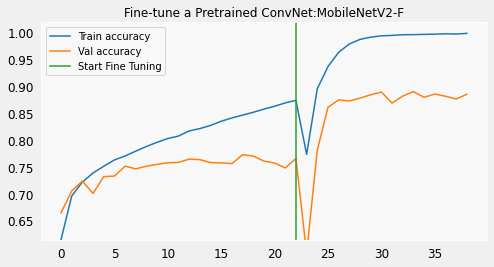

In [ ]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-F")
plt.legend(loc='upper left')

plt.show()

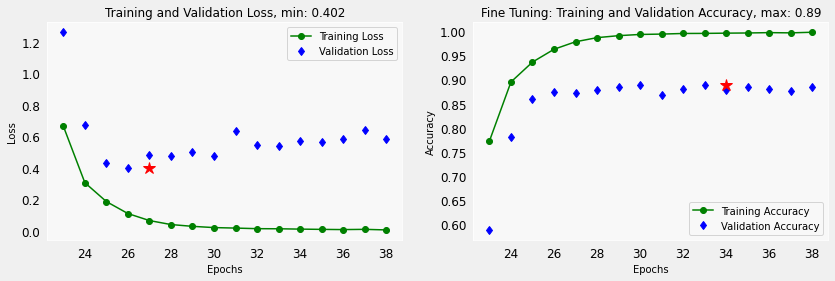

In [ ]:
# More graphs of loss and accuracy in Fine Tuning
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best model
- cifar10pct100_mobileNetV2F_SGD_FT_best_weights.037-0.889.hdf5

### Visualize predictions
We can take a look at the predictions on the validation set.

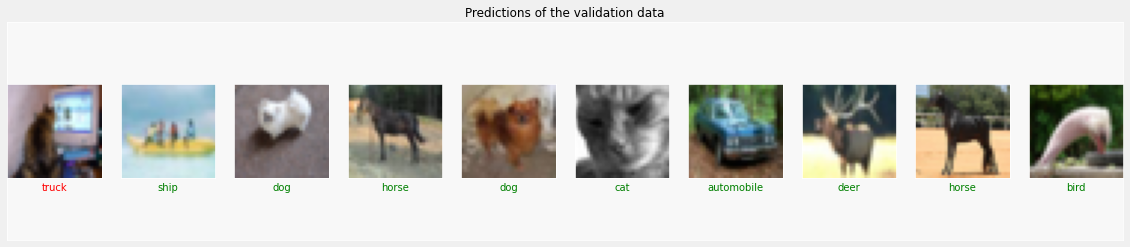

In [ ]:
probabilities = model.predict(x_test, batch_size=BATCH_SIZE)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

---

---

In [ ]:
tf.keras.backend.clear_session()  # For memory

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions.shape

In [ ]:
predictions0 = np.argmax(predictions, axis=1)
predictions0.shape

In [ ]:
cm = confusion_matrix(y_test0, predictions0)

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()